In [0]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [0]:
df = pd.read_table('truth.txt', names=['rus'], header=None)
df2 = pd.read_table('truth-out.txt', names=['eng'], header=None)
df = pd.concat([df, df2], axis=1)

In [0]:
df.shape

(7768, 2)

In [0]:
df.eng = df.eng.apply(lambda x: x.lower())
df.rus = df.rus.apply(lambda x: x.lower())

df.eng = df.eng.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df.rus = df.rus.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

df.eng = df.eng.apply(lambda x: x.translate(str.maketrans('', '', string.digits)))
df.rus = df.rus.apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

df.eng = df.eng.apply(lambda x: re.sub(' +', ' ', x))
df.rus = df.rus.apply(lambda x: re.sub(' +', ' ', x))

df.eng = df.eng.apply(lambda x: 'START_ ' + x + ' _END')

df.head()

,rus,eng
0,исполнительный совет,START_ executive board _END
1,пункт повестки дня,START_ agenda item _END
2,октября года,START_ october _END
3,ноября декабрь,START_ november december _END
4,пункт повестки дня,START_ agenda item _END


In [0]:
def create_vocabulary(df_local, column):
  vocabulary = set()
  for line in df_local[column]:
      for word in line.split():
          if word not in vocabulary:
              vocabulary.add(word)
  return vocabulary

rus_words = create_vocabulary(df, 'rus')
eng_words = create_vocabulary(df, 'eng')

In [0]:
def get_max_sentence_len(df_local, column):
  lenghts = []
  for line in df_local[column]:
      lenghts.append(len(line.split(' ')))
  return np.max(lenghts)

max_length_src = get_max_sentence_len(df, 'rus')
max_length_tar = get_max_sentence_len(df, 'eng')

In [0]:
input_words = sorted(list(rus_words))
target_words = sorted(list(eng_words))
num_encoder_tokens = len(rus_words)
num_decoder_tokens = len(eng_words)
num_decoder_tokens += 1 # For zero padding
num_encoder_tokens, num_decoder_tokens

(24119, 10773)

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
# Train - Test Split
X, y = df.rus, df.eng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((6991,), (777,))

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j + batch_size], y[j:j + batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split()) - 1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t > 0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [0]:
latent_dim = 100

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens + 1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens + 1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

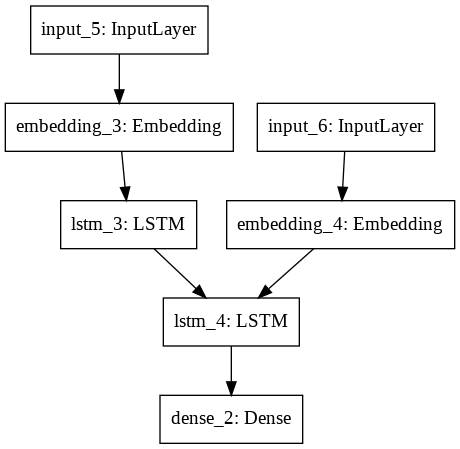

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
model.load_weights('enc_dec_weights.h5')

In [0]:
from keras.callbacks import ModelCheckpoint
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 100
epochs = 2

chekc = ModelCheckpoint(
      filepath='weights.h5', 
      monitor='loss', 
      verbose=0, 
      save_best_only=False,
      save_weights_only=True, 
      mode='auto', 
      period=1
    )

model.fit_generator(generator=generate_batch(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=train_samples // batch_size,
                    epochs=epochs,
                    callbacks=[chekc])

Epoch 1/2


KeyboardInterrupt: ignored

In [0]:
model.save_weights('enc_dec_weights.h5')


In [0]:
from google.colab import files
files.download('enc_dec_weights.h5')

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs2] + decoder_states2
    )

In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence

In [0]:
def sentence2idxs(input_text):
  encoder_input_data = np.zeros(len(input_text))
  for i, word in enumerate(input_text.split(' ')):
    encoder_input_data[i] = input_token_index[word] # encoder input seq
  return encoder_input_data

In [0]:
input_seq = sentence2idxs('должность')
input_seq

array([4741.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])

In [0]:
decode_sequence(input_seq)

' the the the the the the the the the the the the the'

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)


In [0]:

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

In [0]:
with open('result.txt', 'w') as out:
  for line in lines[-500:]['eng']:
    input_seq = sentence2idxs(line)
    translated = decode_sequence(input_seq)
    out.write(translated[:-4] + '\n')